https://github.com/you359/Keras-FasterRCNN

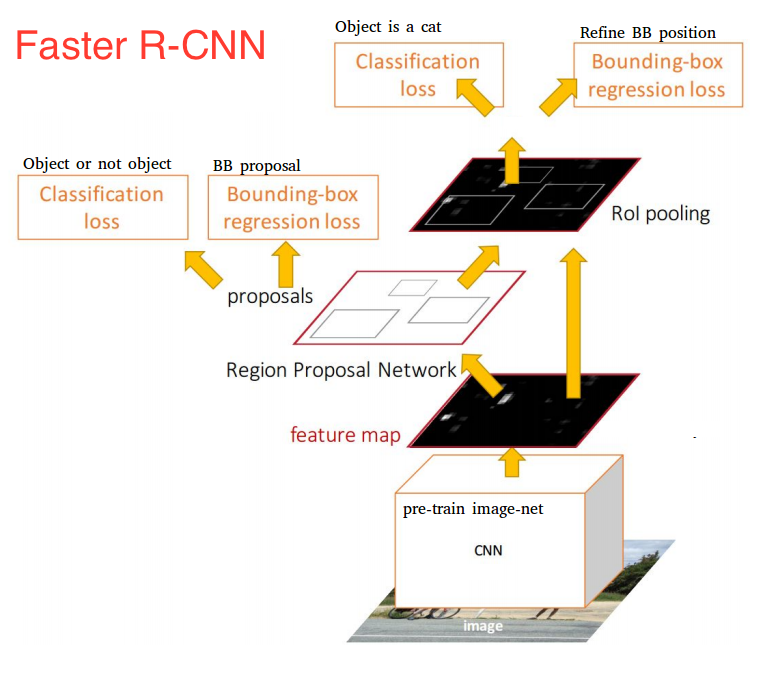

In [1]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard

from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers

from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed

Using TensorFlow backend.


In [2]:
# tensorboard 로그 작성 함수
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

In [3]:
class options:
    train_path = '../../../dataset/VOCtrainval_11-May-2012/VOCdevkit'
    num_rois=32
    network='vgg16'
    horizontal_flips=False
    vertical_flips=False
    rot_90=False
    num_epochs=10
    config_filename='config.pickle'
    output_weight_path='./model_frcnn.hdf5'

In [4]:
os.listdir(options.train_path)

['VOC2012']

In [5]:
# sys.setrecursionlimit(40000)

# parser = OptionParser()

# parser.add_option("-p", "--path", dest="train_path", help="Path to training data.")
# parser.add_option("-o", "--parser", dest="parser", help="Parser to use. One of simple or pascal_voc",
#                   default="pascal_voc")
# parser.add_option("-n", "--num_rois", dest="num_rois", help="Number of RoIs to process at once.", default=32)
# parser.add_option("--network", dest="network", help="Base network to use. Supports vgg or resnet50.", default='resnet50')
# parser.add_option("--hf", dest="horizontal_flips", help="Augment with horizontal flips in training. (Default=false).", action="store_true", default=False)
# parser.add_option("--vf", dest="vertical_flips", help="Augment with vertical flips in training. (Default=false).", action="store_true", default=False)
# parser.add_option("--rot", "--rot_90", dest="rot_90", help="Augment with 90 degree rotations in training. (Default=false).",
#                   action="store_true", default=False)
# parser.add_option("--num_epochs", dest="num_epochs", help="Number of epochs.", default=2000)
# parser.add_option("--config_filename", dest="config_filename",
#                   help="Location to store all the metadata related to the training (to be used when testing).",
#                   default="config.pickle")
# parser.add_option("--output_weight_path", dest="output_weight_path", help="Output path for weights.", default='./model_frcnn.hdf5')
# parser.add_option("--input_weight_path", dest="input_weight_path", help="Input path for weights. If not specified, will try to load default weights provided by keras.")

# (options, args) = parser.parse_args()

# if not options.train_path:   # if filename is not given
#     parser.error('Error: path to training data must be specified. Pass --path to command line')

# if options.parser == 'pascal_voc':
    
# elif options.parser == 'simple':


In [6]:
# from keras_frcnn.simple_parser import get_data

from keras_frcnn.pascal_voc_parser import get_data

In [7]:
class Config:

    def __init__(self):

        self.verbose = True

        # base CNN model
        self.network = 'resnet50'

        # setting for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.rot_90 = False

        # anchor box scales
        self.anchor_box_scales = [128, 256, 512]

        # anchor box ratios
        self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

        # size to resize the smallest side of the image
        self.im_size = 600

        # image channel-wise mean to subtract
        self.img_channel_mean = [103.939, 116.779, 123.68]
        self.img_scaling_factor = 1.0

        # number of ROIs at once
        self.num_rois = 300

        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16

        self.balanced_classes = False

        # scaling the stdev
        self.std_scaling = 4.0
        self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

        # overlaps for RPN
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7

        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5

        # placeholder for the class mapping, automatically generated by the parser
        self.class_mapping = None

        #location of pretrained weights for the base network
        # weight files can be found at:
        # https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5
        # https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

        self.model_path = 'model_frcnn.vgg.hdf5'

In [8]:
C = Config()

C.use_horizontal_flips = bool(options.horizontal_flips)
C.use_vertical_flips = bool(options.vertical_flips)
C.rot_90 = bool(options.rot_90)

C.model_path = options.output_weight_path
C.num_rois = int(options.num_rois)

In [9]:
# # pass the settings from the command line, and persist them in the config object
# C = config.Config()

# C.use_horizontal_flips = bool(options.horizontal_flips)
# C.use_vertical_flips = bool(options.vertical_flips)
# C.rot_90 = bool(options.rot_90)

# C.model_path = options.output_weight_path
# C.num_rois = int(options.num_rois)

# if options.network == 'vgg':
C.network = 'vgg'
from keras_frcnn import vgg as nn
# elif options.network == 'resnet50':
#     from keras_frcnn import resnet as nn
#     C.network = 'resnet50'
# elif options.network == 'xception':
#     from keras_frcnn import xception as nn
#     C.network = 'xception'
# elif options.network == 'inception_resnet_v2':
#     from keras_frcnn import inception_resnet_v2 as nn
#     C.network = 'inception_resnet_v2'
# else:
#     print('Not a valid model')
#     raise ValueError

# check if weight path was passed via command line
# if options.input_weight_path:
#     C.base_net_weights = options.input_weight_path
# else:
# set the path to weights based on backend and model
C.base_net_weights = nn.get_weight_path()

In [10]:
# parser에서 이미지, 클래스, 클래스 맵핑 정보 가져오기
all_imgs, classes_count, class_mapping = get_data(options.train_path)

# bg 클래스 추가
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping

inv_map = {v: k for k, v in class_mapping.items()}

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))

config_output_filename = options.config_filename

with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C, config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

random.shuffle(all_imgs)

num_imgs = len(all_imgs)

train_imgs = [s for s in all_imgs if s['imageset'] == 'train']
val_imgs = [s for s in all_imgs if s['imageset'] == 'val']
test_imgs = [s for s in all_imgs if s['imageset'] == 'test']

print('Num train samples {}'.format(len(train_imgs)))
print('Num val samples {}'.format(len(val_imgs)))
print('Num test samples {}'.format(len(test_imgs)))

Parsing annotation files


Processing 2012_004331.xml: 100%|███████████████████████████████████████████████| 17125/17125 [00:32<00:00, 531.35it/s]


Training images per class:
{'aeroplane': 954,
 'bg': 0,
 'bicycle': 790,
 'bird': 1221,
 'boat': 999,
 'bottle': 1482,
 'bus': 637,
 'car': 2364,
 'cat': 1227,
 'chair': 2906,
 'cow': 702,
 'diningtable': 747,
 'dog': 1541,
 'horse': 750,
 'motorbike': 751,
 'person': 10129,
 'pottedplant': 1099,
 'sheep': 994,
 'sofa': 786,
 'train': 656,
 'tvmonitor': 826}
Num classes (including bg) = 21
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 5717
Num val samples 5823
Num test samples 0


In [11]:
# groundtruth anchor 데이터 가져오기
data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, nn.get_img_output_length, mode='train')
data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, nn.get_img_output_length, mode='val')
data_gen_test = data_generators.get_anchor_gt(test_imgs, classes_count, C, nn.get_img_output_length, mode='val')

In [12]:
input_shape_img = (256, 256, 3)

# input placeholder 정의
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

# base network(feature extractor) 정의 (resnet, VGG, Inception, Inception Resnet V2, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

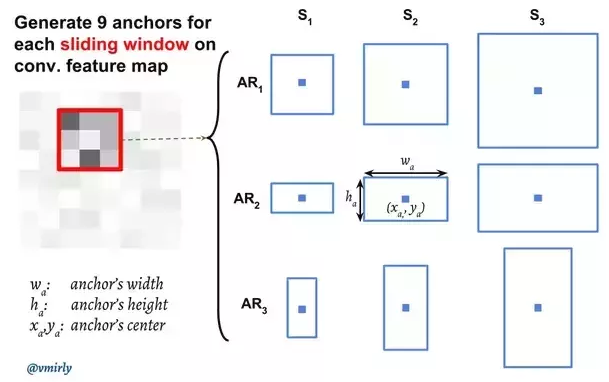

# RPN

http://incredible.ai/deep-learning/2018/03/17/Faster-R-CNN/

In [13]:
def rpn_layer(base_layers, num_anchors):

    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

In [14]:
# define the RPN, built on the base layers
# RPN 정의
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = rpn_layer(shared_layers, num_anchors)

In [15]:
rpn

[<tf.Tensor 'rpn_out_class/Identity:0' shape=(None, 16, 16, 9) dtype=float32>,
 <tf.Tensor 'rpn_out_regress/Identity:0' shape=(None, 16, 16, 36) dtype=float32>,
 <tf.Tensor 'block5_conv3/Identity:0' shape=(None, 16, 16, 512) dtype=float32>]

In [16]:
shared_layers

<tf.Tensor 'block5_conv3/Identity:0' shape=(None, 16, 16, 512) dtype=float32>

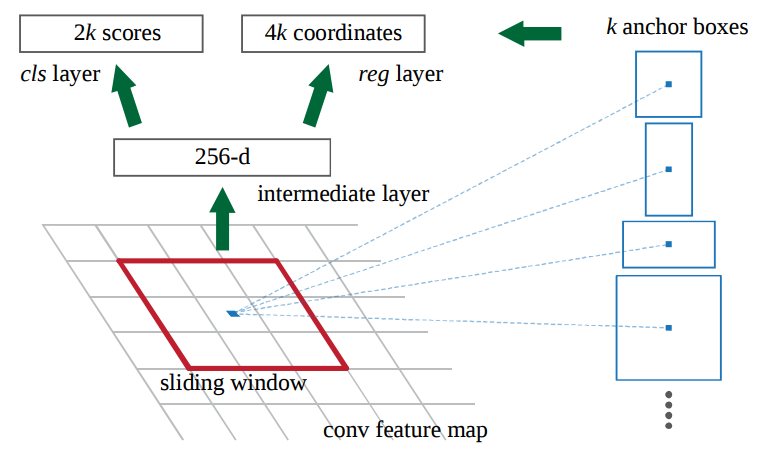

# Roi Pooling Conv

In [17]:
class RoiPoolingConv(Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []
        
        print("num_rois :", self.num_rois)
        print('rois:', rois)
        
        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

In [18]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):

    # compile times on theano tend to be very high, so we use smaller ROI pooling regions to workaround

    pooling_regions = 7
    input_shape = (num_rois, 7, 7, 512)

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

# Classifier and Regressor

In [19]:
# detection network 정의
classifier = classifier_layer(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

num_rois : 32
rois: Tensor("input_2:0", shape=(None, None, 4), dtype=float32)


In [20]:
img_input

<tf.Tensor 'input_1:0' shape=(None, 256, 256, 3) dtype=float32>

In [21]:
roi_input

<tf.Tensor 'input_2:0' shape=(None, None, 4) dtype=float32>

In [22]:
model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

In [23]:
rpn

[<tf.Tensor 'rpn_out_class/Identity:0' shape=(None, 16, 16, 9) dtype=float32>,
 <tf.Tensor 'rpn_out_regress/Identity:0' shape=(None, 16, 16, 36) dtype=float32>,
 <tf.Tensor 'block5_conv3/Identity:0' shape=(None, 16, 16, 512) dtype=float32>]

In [24]:
# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

In [25]:
try:
    # load_weights by name
    # some keras application model does not containing name
    # for this kinds of model, we need to re-construct model with naming
    print('loading weights from {}'.format(C.base_net_weights))
    model_rpn.load_weights(C.base_net_weights, by_name=True)
    model_classifier.load_weights(C.base_net_weights, by_name=True)
except:
    print('Could not load pretrained model weights. Weights can be found in the keras application folder \
        https://github.com/fchollet/keras/tree/master/keras/applications')

loading weights from vgg16_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder         https://github.com/fchollet/keras/tree/master/keras/applications


In [26]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

# Tensorboard log폴더 생성
log_path = './logs'
if not os.path.isdir(log_path):
    os.mkdir(log_path)

# Tensorboard log모델 연결
callback = TensorBoard(log_path)
callback.set_model(model_all)

epoch_length = 1000
num_epochs = int(options.num_epochs)
iter_num = 0
train_step = 0

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}
print('Starting training')

# vis = True

W0830 04:23:08.167882 28140 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Layers with arguments in `__init__` must override `get_config`.


Starting training


In [27]:
for epoch_num in range(num_epochs):

    progbar = utils.Progbar(epoch_length)   # keras progress bar 사용
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

    while True:
        # try:
        # mean overlapping bboxes 출력
        if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
            mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
            rpn_accuracy_rpn_monitor = []
            print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
            if mean_overlapping_bboxes == 0:
                print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

        # data generator에서 X, Y, image 가져오기
        X, Y, img_data = next(data_gen_train)

        loss_rpn = model_rpn.train_on_batch(X, Y)
        write_log(callback, ['rpn_cls_loss', 'rpn_reg_loss'], loss_rpn, train_step)

        P_rpn = model_rpn.predict_on_batch(X)

        R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
        # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
        X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

        if X2 is None:
            rpn_accuracy_rpn_monitor.append(0)
            rpn_accuracy_for_epoch.append(0)
            continue

        # sampling positive/negative samples
        neg_samples = np.where(Y1[0, :, -1] == 1)
        pos_samples = np.where(Y1[0, :, -1] == 0)

        if len(neg_samples) > 0:
            neg_samples = neg_samples[0]
        else:
            neg_samples = []

        if len(pos_samples) > 0:
            pos_samples = pos_samples[0]
        else:
            pos_samples = []

        rpn_accuracy_rpn_monitor.append(len(pos_samples))
        rpn_accuracy_for_epoch.append((len(pos_samples)))

        if C.num_rois > 1:
            if len(pos_samples) < C.num_rois//2:
                selected_pos_samples = pos_samples.tolist()
            else:
                selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
            try:
                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
            except:
                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

            sel_samples = selected_pos_samples + selected_neg_samples
        else:
            # in the extreme case where num_rois = 1, we pick a random pos or neg sample
            selected_pos_samples = pos_samples.tolist()
            selected_neg_samples = neg_samples.tolist()
            if np.random.randint(0, 2):
                sel_samples = random.choice(neg_samples)
            else:
                sel_samples = random.choice(pos_samples)

        loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
        write_log(callback, ['detection_cls_loss', 'detection_reg_loss', 'detection_acc'], loss_class, train_step)
        train_step += 1

        losses[iter_num, 0] = loss_rpn[1]
        losses[iter_num, 1] = loss_rpn[2]

        losses[iter_num, 2] = loss_class[1]
        losses[iter_num, 3] = loss_class[2]
        losses[iter_num, 4] = loss_class[3]

        iter_num += 1

        progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                  ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])

        if iter_num == epoch_length:
            loss_rpn_cls = np.mean(losses[:, 0])
            loss_rpn_regr = np.mean(losses[:, 1])
            loss_class_cls = np.mean(losses[:, 2])
            loss_class_regr = np.mean(losses[:, 3])
            class_acc = np.mean(losses[:, 4])

            mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
            rpn_accuracy_for_epoch = []

            if C.verbose:
                print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                print('Loss RPN regression: {}'.format(loss_rpn_regr))
                print('Loss Detector classifier: {}'.format(loss_class_cls))
                print('Loss Detector regression: {}'.format(loss_class_regr))
                print('Elapsed time: {}'.format(time.time() - start_time))

            curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
            iter_num = 0
            start_time = time.time()

            write_log(callback,
                      ['Elapsed_time', 'mean_overlapping_bboxes', 'mean_rpn_cls_loss', 'mean_rpn_reg_loss',
                       'mean_detection_cls_loss', 'mean_detection_reg_loss', 'mean_detection_acc', 'total_loss'],
                      [time.time() - start_time, mean_overlapping_bboxes, loss_rpn_cls, loss_rpn_regr,
                       loss_class_cls, loss_class_regr, class_acc, curr_loss],
                      epoch_num)

            if curr_loss < best_loss:
                if C.verbose:
                    print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model_all.save_weights(C.model_path)

            break

        # except Exception as e:
        #     print('Exception: {}'.format(e))
        #     continue

print('Training complete, exiting.')

Epoch 1/10


KeyboardInterrupt: 